In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Langkah 1 : Import Library

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

Langkah 2: Memuat dataset CIFAR 1O

In [ ]:

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

170498071/170498071 [==============================] - 7s 0us/step
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


Langkah 3 : Normalisasi data dan konversi label ke vektor one-hot encoded

In [ ]:
# Mengonversi tipe data gambar menjadi float32 dan membagi setiap nilai piksel dengan 255.0.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
# Menetapkan jumlah kelas atau kategori pada dataset.
num_classes = 10
# Mengonversi label kelas (yaitu, kategori) menjadi representasi one-hot encoding menggunakan to_categorical dari Keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Langkah 4: Memisahkan data latih menjadi data latih dan data validasi

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Langkah 5: Mendefinisikan model Convolutional Neural Network (CNN)

In [ ]:
# Fungsi cnn_model ini mendefinisikan arsitektur sebuah model Convolutional Neural Network (CNN) dengan beberapa lapisan konvolusi, pooling, dropout, dan lapisan fully connected
def cnn_model():
    model = Sequential()
    # First Conv layer
    # 128 filter dengan ukuran kernel (3,3).
    # Fungsi aktivasi ReLU.
    # Padding 'same' untuk memastikan ukuran gambar tidak berkurang.
    # Regularisasi L2 dengan faktor 1e-4.
    # Input shape (32, 32, 3).
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32,32,3)))
    # Lapisan MaxPooling Pertama: Pooling size (2,2), Dropout dengan tingkat dropout 0.3.
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Second Conv layer
    # 256 filter dengan ukuran kernel (3,3).
    # Fungsi aktivasi ReLU.
    # Padding 'same'.
    # Regularisasi L2.
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    # Lapisan MaxPooling Kedua: Pooling size (2,2). Dropout dengan tingkat dropout 0.3.
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Third, fourth, fifth convolution layer
    # Masing-masing dengan jumlah filter yang berbeda (512, 512, 256).
    # Fungsi aktivasi ReLU.
    # Padding 'same'.
    # Regularisasi L2.
    # MaxPooling dan Dropout setelah lapisan ketiga.
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully Connected layers
    # Flatten layer untuk meratakan output dari lapisan konvolusi sebelumnya.
    # Dense layer dengan 512 neuron dan fungsi aktivasi ReLU.
    # Dropout dengan tingkat dropout 0.5.
    # Dense layer dengan 256 neuron dan fungsi aktivasi ReLU.
    # Dropout dengan tingkat dropout 0.5.
    # Dense layer dengan 128 neuron dan fungsi aktivasi ReLU.
    # Dropout dengan tingkat dropout 0.5.
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Lapisan Output:
    # Dense layer dengan 10 neuron (sesuai dengan jumlah kelas pada dataset CIFAR-10).
    # Fungsi aktivasi softmax untuk tugas klasifikasi multikelas.
    model.add(Dense(10, activation='softmax'))

    # model.summary() digunakan untuk menampilkan ringkasan arsitektur model.
    model.summary()
    return model

Langkah 6: Membuat objek ImageDataGenerator dan mempersiapkan augmentasi data

In [ ]:
# Pengaturan untuk pre-processing seperti rata-rata fitur, normalisasi standar, dan whitening ZCA. Dalam kode ini, semuanya diatur ke False.
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    # Rentang rotasi yang dapat diterapkan pada gambar, diatur ke 15 derajat.
    rotation_range=15,
    # Rentang pergeseran lebar dan tinggi yang dapat diterapkan pada gambar, diatur ke 0.1.
    width_shift_range=0.1,
    height_shift_range=0.1,
    # Flip horizontal, diatur ke True.
    horizontal_flip=True,
    # Flip vertikal, diatur ke False.
    vertical_flip=False
)
# menghitung statistik penting seperti rata-rata, deviasi standar, dan komponen ZCA (apabila diaktifkan) dari data pelatihan. 
datagen.fit(X_train)

Langkah 7: Membuat model dan mengompilasi

In [ ]:
# memanggil fungsi cnn_model() untuk membuat model CNN, dan 
# kemudian mengompilasi model tersebut dengan pengaturan tertentu menggunakan metode compile
model = cnn_model()
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0003),
    # mengukur kinerja model selama pelatihan dan evaluasi.
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 256)         0

Langkah 8: Melatih model dengan ImageDataGenerator

In [ ]:
# menggunakan metode fit untuk melatih model dengan menggunakan generator augmentasi data
history = model.fit(
    # memberikan batch data augmentasi pada setiap iterasi
    datagen.flow(X_train, y_train, batch_size=64),
    # Menentukan jumlah langkah (steps) yang akan diambil pada setiap epoch
    steps_per_epoch=len(X_train) // 64,
    epochs=50,
    # Menentukan data validasi yang akan digunakan untuk mengukur kinerja model selama pelatihan.
    validation_data=(X_valid, y_valid),
    # Menentukan tingkat verbosity selama pelatihan. Dengan nilai 1, akan menampilkan informasi pelatihan pada setiap epoch.
    verbose=1
)

Epoch 1/50
625/625 [==============================] - 51s 58ms/step - loss: 2.1252 - accuracy: 0.2052 - val_loss: 1.7671 - val_accuracy: 0.3191
Epoch 2/50
625/625 [==============================] - 35s 55ms/step - loss: 1.7311 - accuracy: 0.3511 - val_loss: 1.4739 - val_accuracy: 0.4568
Epoch 3/50
625/625 [==============================] - 35s 55ms/step - loss: 1.5284 - accuracy: 0.4516 - val_loss: 1.3316 - val_accuracy: 0.5081
Epoch 4/50
625/625 [==============================] - 36s 57ms/step - loss: 1.3979 - accuracy: 0.5145 - val_loss: 1.1872 - val_accuracy: 0.5840
Epoch 5/50
625/625 [==============================] - 36s 58ms/step - loss: 1.3045 - accuracy: 0.5566 - val_loss: 1.0977 - val_accuracy: 0.6200
Epoch 6/50
625/625 [==============================] - 35s 56ms/step - loss: 1.2245 - accuracy: 0.5897 - val_loss: 1.0914 - val_accuracy: 0.6263
Epoch 7/50
625/625 [==============================] - 36s 58ms/step - loss: 1.1716 - accuracy: 0.6119 - val_loss: 0.9997 - val_accuracy:

Langkah 9: Mengevaluasi model pada set tes

In [ ]:
# Metode evaluate mengembalikan nilai-nilai loss dan metrik yang telah ditentukan saat mengompilasi model, dalam hal ini akurasi karena menggunakan metrik 'accuracy'
scores = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.6216 - accuracy: 0.8505


Langkah 10: Melakukan prediksi

<Axes: >

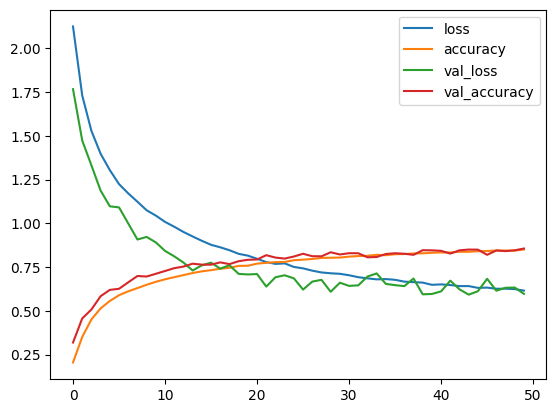

In [ ]:
pd.DataFrame(history.history).plot()

Langkah 11: Tampilkan laporan klasifikasi

In [ ]:
scores = model.evaluate(X_test, y_test)
# Menggunakan model untuk membuat prediksi pada data uji (X_test).
pred = model.predict(X_test)
# Menetapkan label kelas sesuai dengan kelas pada dataset. Ini akan digunakan dalam laporan klasifikasi.
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# Mengambil indeks kelas dengan nilai tertinggi sebagai prediksi, dan mengambil indeks kelas dengan nilai tertinggi sebagai label sebenarnya.
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Mencari indeks di mana prediksi tidak cocok dengan label sebenarnya, dan menyimpannya dalam variabel errors.
errors = y_pred - y_true != 0
# Mencetak laporan klasifikasi menggunakan classification_report dari scikit-learn.
print(classification_report(y_true, y_pred))

313/313 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1000
           1       0.91      0.95      0.93      1000
           2       0.84      0.75      0.80      1000
           3       0.81      0.62      0.70      1000
           4       0.77      0.87      0.82      1000
           5       0.78      0.77      0.77      1000
           6       0.83      0.92      0.87      1000
           7       0.89      0.89      0.89      1000
           8       0.93      0.92      0.93      1000
           9       0.90      0.91      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Langkah 12: Menampilkan visualisasi hasil prediksi

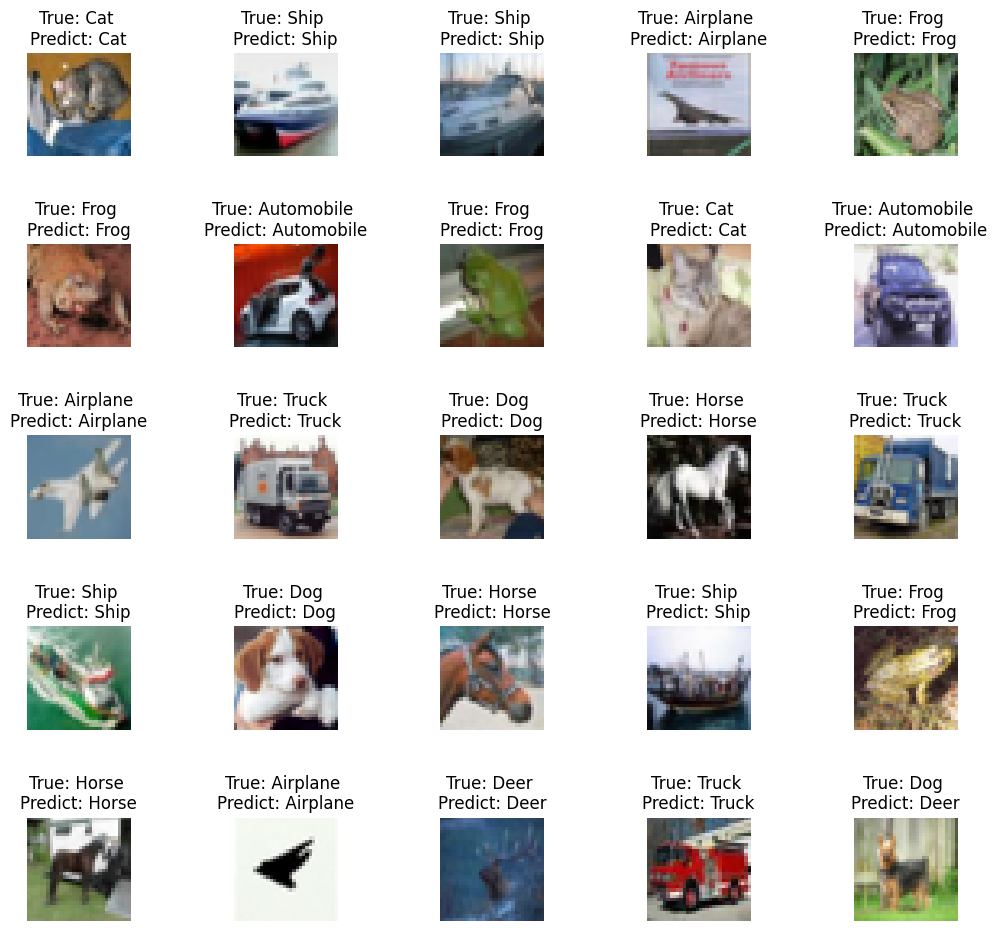

In [ ]:
# Membuat suatu objek figure dan axes grid dengan ukuran 5x5 untuk menampung 25 gambar.
fig, axes = plt.subplots(5, 5, figsize=(12,12))
# Meratakan array 2D axes menjadi array 1D.
axes = axes.ravel()
#  Mengiterasi melalui 25 gambar uji.
for i in np.arange(25):
    # Menampilkan gambar ke-i pada sumbu ke-i.
    axes[i].imshow(X_test[i])
    #  Menetapkan judul untuk setiap gambar yang mencakup label sebenarnya dan prediksi model.
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_true[i]], labels[y_pred[i]]))
    # Menonaktifkan sumbu untuk memperindah tampilan.
    axes[i].axis('off')
    # Menyesuaikan jarak antar subplot secara horizontal.
    plt.subplots_adjust(wspace=1)

Buatlah model CNN untuk klasifikasi dataset MNIST
Langkah 1: Memuat Dataset MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Memuat dataset MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


11490434/11490434 [==============================] - 1s 0us/step


Langkah 2: Normalisasi Gambar ke Rentang [0, 1]

In [ ]:
# Normalisasi gambar ke rentang [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0


Langkah 3: Mengonversi Label ke Format One-Hot Encoding

In [ ]:
# Perbaikan: Mengimpor to_categorical dari tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical

# Mengonversi label ke format one-hot encoding
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

Langkah 4: Menampilkan Informasi tentang Dataset

In [ ]:
# Menampilkan informasi tentang dataset
print("Jumlah data latihan:", len(train_images))
print("Jumlah data pengujian:", len(test_images))
print("Ukuran gambar:", train_images[0].shape)

Jumlah data latihan: 60000
Jumlah data pengujian: 10000
Ukuran gambar: (28, 28)


Langkah 5: Membangun Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Membangun model
model = Sequential()
# Menambahkan lapisan konvolusi dengan 32 filter, ukuran kernel (3,3), fungsi aktivasi ReLU, dan input shape (28, 28, 1).
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
# Menambahkan lapisan MaxPooling untuk mengurangi dimensi gambar setelah lapisan konvolusi pertama.
model.add(MaxPooling2D((2, 2)))
# Menambahkan lapisan konvolusi kedua dengan 64 filter dan ukuran kernel (3,3).
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Menambahkan lapisan MaxPooling setelah lapisan konvolusi kedua.
model.add(MaxPooling2D((2, 2)))
# Meratakan output dari lapisan sebelumnya menjadi vektor satu dimensi.
model.add(Flatten())
# Menambahkan lapisan dense dengan 128 neuron dan fungsi aktivasi ReLU. 
model.add(Dense(128, activation='relu'))
# menambahkan dropout dengan tingkat dropout sebesar 0.2 untuk mengurangi overfitting.
model.add(Dropout(0.2))
# Menambahkan lapisan dense kedua dengan 64 neuron, fungsi aktivasi ReLU, dan dropout.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# Menambahkan lapisan output dengan 10 neuron (sesuai dengan jumlah kelas) dan fungsi aktivasi softmax untuk tugas klasifikasi multikelas.
model.add(Dense(10, activation='softmax'))

Langkah 6: Mengompilasi Model

In [ ]:
# Mengompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Langkah 7: Menampilkan Ringkasan Model

In [ ]:
# Menampilkan ringkasan model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

Langkah 8: Melatih Model

In [ ]:
# Melatih model
history = model.fit(train_images, train_labels, epochs=10, batch_size=128, verbose=2, validation_split=0.3)


Epoch 1/10
329/329 - 4s - loss: 0.3607 - accuracy: 0.8882 - val_loss: 0.0857 - val_accuracy: 0.9739 - 4s/epoch - 12ms/step
Epoch 2/10
329/329 - 2s - loss: 0.0893 - accuracy: 0.9736 - val_loss: 0.0542 - val_accuracy: 0.9836 - 2s/epoch - 6ms/step
Epoch 3/10
329/329 - 2s - loss: 0.0647 - accuracy: 0.9810 - val_loss: 0.0482 - val_accuracy: 0.9856 - 2s/epoch - 7ms/step
Epoch 4/10
329/329 - 2s - loss: 0.0484 - accuracy: 0.9856 - val_loss: 0.0460 - val_accuracy: 0.9863 - 2s/epoch - 7ms/step
Epoch 5/10
329/329 - 2s - loss: 0.0417 - accuracy: 0.9870 - val_loss: 0.0437 - val_accuracy: 0.9874 - 2s/epoch - 6ms/step
Epoch 6/10
329/329 - 2s - loss: 0.0348 - accuracy: 0.9896 - val_loss: 0.0404 - val_accuracy: 0.9887 - 2s/epoch - 6ms/step
Epoch 7/10
329/329 - 2s - loss: 0.0310 - accuracy: 0.9908 - val_loss: 0.0388 - val_accuracy: 0.9884 - 2s/epoch - 5ms/step
Epoch 8/10
329/329 - 2s - loss: 0.0237 - accuracy: 0.9925 - val_loss: 0.0396 - val_accuracy: 0.9897 - 2s/epoch - 6ms/step
Epoch 9/10
329/329 - 2s

Langkah 9: Plot Sejarah Pelatihan

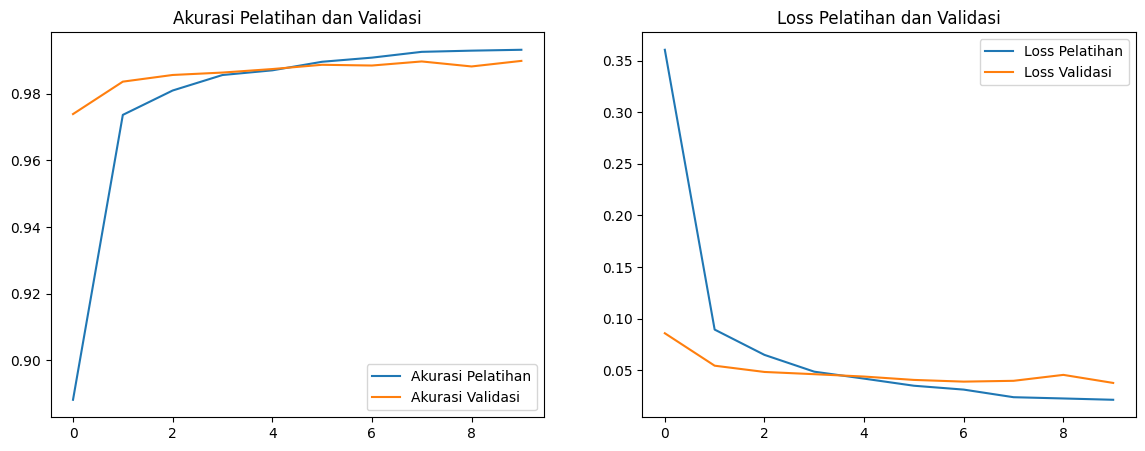

In [ ]:
import matplotlib.pyplot as plt

# Membuat objek figure dengan ukuran (14, 5) untuk menampung dua subplot.
plt.figure(figsize=(14, 5))

# Membuat subplot pertama di grid 1x2 dan membuat plot garis untuk akurasi pelatihan dan validasi dari history. 
# Menambahkan legenda dan judul subplot.
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Pelatihan dan Validasi')

# Membuat subplot kedua di grid 1x2 dan membuat plot garis untuk loss pelatihan dan validasi dari history. 
# Menambahkan legenda dan judul subplot.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Pelatihan dan Validasi')

# Menampilkan plot secara keseluruhan.
plt.show()

Langkah 10: Evaluasi Model pada Kumpulan Data Uji

In [ ]:
# Evaluasi model pada kumpulan data uji
validation_loss, validation_accuracy = model.evaluate(test_images, test_labels, verbose=False)
print("Loss Validasi:", validation_loss)
print("Akurasi Validasi:", validation_accuracy)

Loss Validasi: 0.026648346334695816
Akurasi Validasi: 0.9922000169754028


Langkah 11: Menghasilkan Nilai Prediksi pada Kumpulan Data Uji

In [ ]:
# Menghasilkan nilai prediksi pada kumpulan data uji
y_pred_enc = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


Langkah 12: Mendekode Nilai Prediksi

In [ ]:
# Mendekode nilai prediksi
y_pred = [np.argmax(i) for i in y_pred_enc]

Langkah 13: Menampilkan Laporan Klasifikasi

In [ ]:
# Menampilkan laporan klasifikasi
print(classification_report(np.argmax(test_labels, axis=1), y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



Langkah 14: Membuat Matriks Konfusi dan Menampilkannya dengan Heatmap

Text(58.222222222222214, 0.5, 'Aktual')

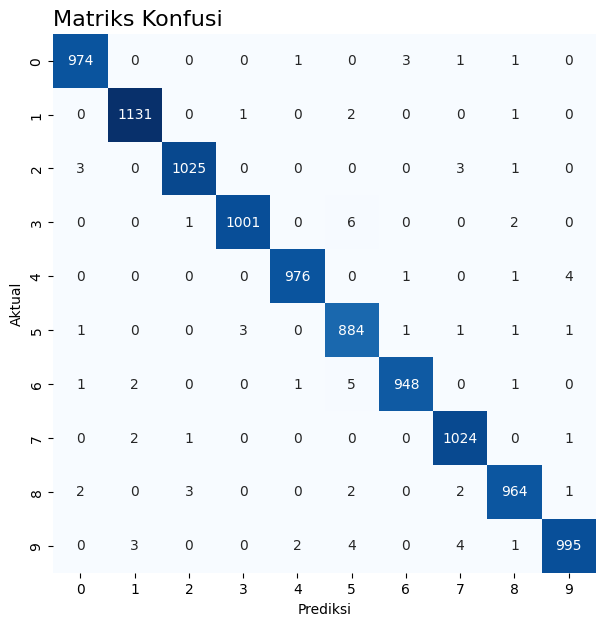

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Membuat objek figure dan axis untuk menampung heatmap. Ukuran figur diatur menjadi (7, 7).
fig, ax = plt.subplots(figsize=(7, 7))
# Menggunakan Seaborn untuk membuat heatmap dari matriks konfusi.
sns.heatmap(confusion_matrix(np.argmax(test_labels, axis=1), y_pred), annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)
# Menetapkan judul dan label sumbu pada heatmap.
ax.set_title('Matriks Konfusi', loc='left', fontsize=16)
ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')

Langkah 15: Menampilkan Target yang Diprediksi pada Setiap Gambar (Label di atas gambar adalah label yang diprediksi)

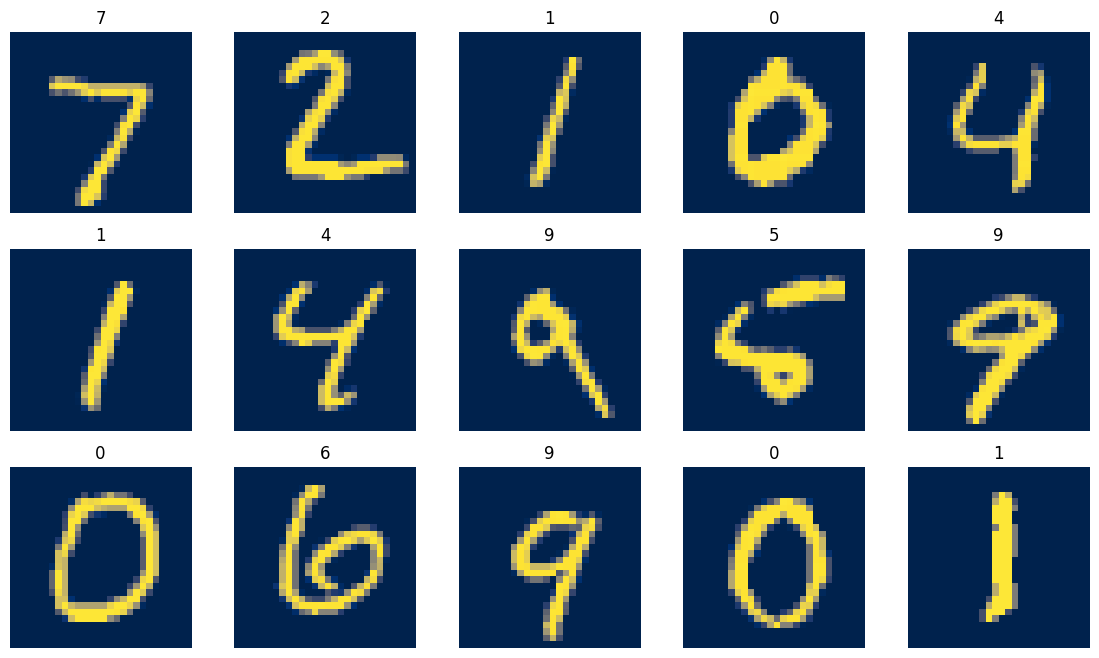

In [ ]:
# Menampilkan target yang diprediksi pada setiap gambar
# (label di atas gambar adalah label yang diprediksi)
plt.figure(figsize=(14, 8))
# Iterasi melalui 15 gambar pertama dari data uji (test_images).
for ind, row in enumerate(test_images[:15]):
    # Membuat subplot dalam grid 3x5 dan menetapkan subplot ke indeks ind+1
    plt.subplot(3, 5, ind+1)
    # Menetapkan judul subplot dengan prediksi yang diberikan oleh model pada gambar tersebut (y_pred[ind]).
    plt.title(y_pred[ind])
    # Mereshape gambar menjadi bentuk (28, 28) karena gambar asli memiliki bentuk (784,).
    img = row.reshape(28, 28)
    # Menonaktifkan sumbu untuk memperindah tampilan.
    plt.axis('off')
    # Menampilkan gambar pada subplot dengan menggunakan skema warna 'cividis'.
    plt.imshow(img, cmap='cividis')